# 0 - Instalation of modules

#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [33]:
%reset

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [3]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [4]:
#On garde les NB_FILM films les plus notés
NB_FILM = 10000
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(24409923, 3)

In [5]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.3
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [6]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
#user_title_df.to_csv(f"{data_folder}user_title.csv")
user_title_df.shape

(66, 9996)

# 4 - Colaborative filtering

In [3]:
#Récupérer les données si elles sont en local
user_title_df = pd.read_csv(f"{data_folder}user_title.csv", index_col=0)

## 4.1 - General function

In [9]:
#Standardisation des lignes pour supprimer les biais
def standardize(row):
    return row - np.mean(row)

In [13]:
#On garde les candidats similaire et complétement opposé
def create_cluster(feature, eps, save=False, name=None):
    cluster = {feat : {"+" : [], "-" : []} for feat in feature}

    i = 1
    for feat1 in tqdm(feature):
        for feat2 in feature[i:]:
            tmp = thresh.loc[feat1, feat2]

            if (tmp >= eps):
                cluster[feat1]["+"].append(feat2)
                cluster[feat2]["+"].append(feat1)
            elif (tmp <= -eps):
                cluster[feat1]["-"].append(feat2)
                cluster[feat2]["-"].append(feat1)

        i += 1

    if save:
        pd.DataFrame.from_dict(cluster).T.to_csv(f"{data_folder}{name}.csv")

    return cluster

## 4.2 - Users to users

In [9]:
#On devine la note en fonction des candidtats similaires
def guess_rate_cluster(user, title):
    rate = 0
    coeff = 0

    for u in cluster[user]["+"]:
        if not (pd.isnull(user_title_df.loc[u, title])):
            rate += cos_df.loc[user, u]*user_title_df.loc[u, title]
            coeff += cos_df.loc[user, u]

    if (coeff == 0):
        return 2.5
    else:   
        return rate/coeff

In [10]:
#On devine la note en fonction de tous les candidats
def guess_rate_all(user, title):
    rate = 0
    coef = 0

    for i in user_title_df.index:
        if (i != user) and not (pd.isnull(user_title_df.loc[i, title])):
            rate += cos_df.loc[user, i]*user_title_df.loc[i, title]
            coef += cos_df.loc[user, i]

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [ ]:
user_title_std = user_title_df.apply(standardize, axis=1).fillna(0)
user_title_std.shape

In [5]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std)
cos_df = pd.DataFrame(cos, index=user_title_std.index, columns=user_title_std.index)
del(cos)

In [7]:
#Création
thresh = cos_df[(cos_df >= 0.7) & (cos_df < 0.999999999)]
thresh = thresh.dropna(axis=1, thresh=1).dropna(axis=0, thresh=1)
thresh.shape

(338, 338)

In [ ]:
cluster = create_cluster(thresh.index, 0.7, True; "cluster_users")

In [17]:
N = 20
all_none_empty_cluster = []

for k in cluster.keys():
    if (len(cluster[k]["+"]) >= N):
        all_none_empty_cluster.append(k)
len(all_none_empty_cluster)

11

In [ ]:
#On compare les deux méthodes
from time import time

compare_time = {}

for N in tqdm([5, 10, 15, 20]):
    all_none_empty_cluster = []
    compare_time[f"Cluster {N}"] = {"Cluster" : {"Times" : [], "Rates" : []}, "All" : {"Times" : [], "Rates" : []}}

    for k in cluster.keys():
        if (len(cluster[k]["+"]) >= N-1 and len(cluster[k]["+"]) <= N+1):
            all_none_empty_cluster.append(k)

    users = all_none_empty_cluster[:10]
    titles = user_title_df.columns
    sup = []
    positif = []

    for user in tqdm(users, leave=False):
        for title in titles[:100]:
            start = time()
            cluster_rate = guess_rate_cluster(user, title)
            cluster_time = time() - start
            compare_time[f"Cluster {N}"]["Cluster"]["Rates"].append(cluster_rate)
            compare_time[f"Cluster {N}"]["Cluster"]["Times"].append(cluster_time)

            start = time()
            all_rate = guess_rate_all(user, title)
            all_time = time() - start
            compare_time[f"Cluster {N}"]["All"]["Rates"].append(all_rate)
            compare_time[f"Cluster {N}"]["All"]["Times"].append(all_time)
            
            sup.append(1) if (cluster_rate - all_rate < 0) else sup.append(0) 
            positif.append(1) if (cluster_time - all_time > 0) else positif.append(0)

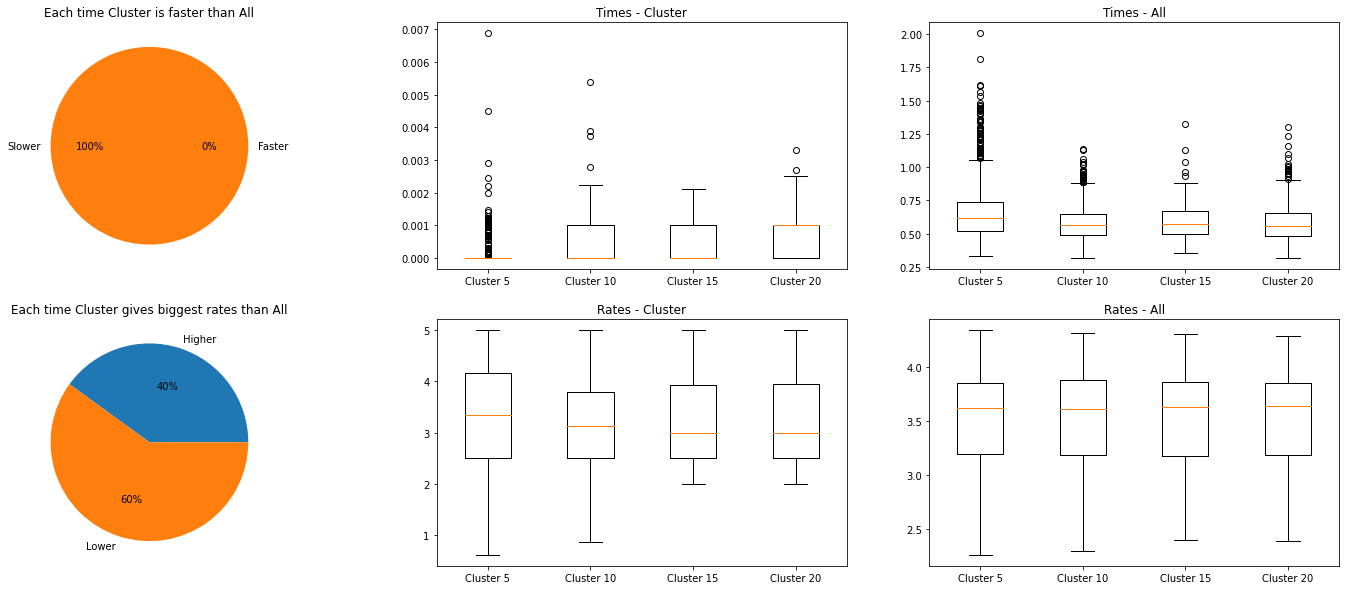

In [34]:
#On affiche graphiquement le comparatif
plt.figure(figsize=(25,10))

k = 1
for stat in ["Times", "Rates"]:
    plt.subplot(2, 3, k)
    if (k == 1):
        n = np.sum(positif)
        plt.pie([n, len(positif)-n], labels=["Faster", "Slower"], autopct='%.0f%%')
        plt.title("Each time Cluster is faster than All")
    elif (k == 4):
        n = np.sum(sup)
        plt.pie([n, len(sup)-n], labels=["Higher", "Lower"], autopct='%.0f%%')
        plt.title("Each time Cluster gives biggest rates than All")
    k += 1

    for method in ["Cluster", "All"]:
        plots = []
        labels = []

        for key in compare_time.keys():
            labels.append(key)
            plots.append(compare_time[key][method][stat])

        plt.subplot(2, 3, k)
        plt.boxplot(plots, labels=labels)
        plt.title(f"{stat} - {method}")

        k += 1

plt.show()

In [ ]:
compare = {}

for N in [5, 10, 15, 20]:
    all_none_empty_cluster = []
    compare[f"Cluster {N}"] = {"True" : [], "Cluster" : [], "All" : []}

    for k in cluster.keys():
        if (len(cluster[k]["+"]) >= N-1 and len(cluster[k]["+"]) <= N+1):
            all_none_empty_cluster.append(k)

    for user in tqdm(all_none_empty_cluster[:10]):
        all_rated_film = user_title_df.loc[user].dropna(axis=0)
        compare[f"Cluster {N}"]["True"] += all_rated_film.values.tolist()
        
        for movie in all_rated_film.index:
            compare[f"Cluster {N}"]["Cluster"].append(guess_rate_cluster(user, movie))
            compare[f"Cluster {N}"]["All"].append(guess_rate_all(user, movie))

compare_df = pd.DataFrame.from_dict(compare)
compare_df.to_csv(f"{data_folder}compare_true_cluster_all.csv")
del(compare)


delta = {"Cluster" : {}, "All" : {}}

for col in compare_df.columns:
    delta["Cluster"][col] = []
    delta["All"][col] = []

    for i in range(len(compare_df[col]["Cluster"])):
        delta["Cluster"][col].append(compare_df[col]["True"][i]-compare_df[col]["Cluster"][i])
        delta["All"][col].append(compare_df[col]["True"][i]-compare_df[col]["All"][i])

compare_delta_df = pd.DataFrame.from_dict(delta)

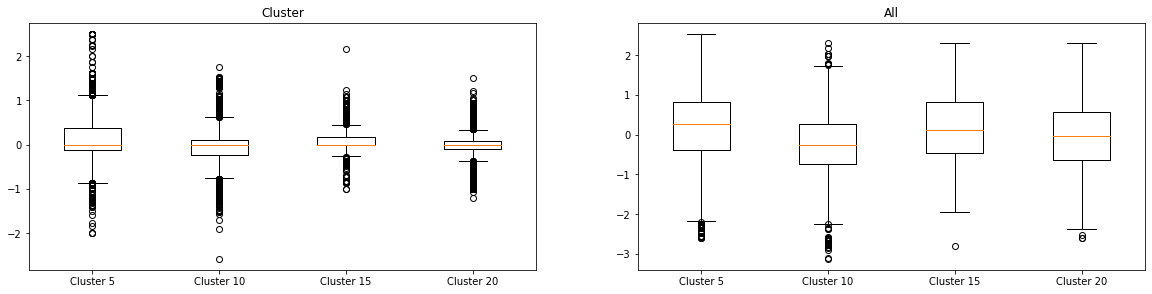

In [48]:
plt.figure(figsize=(20,10))

k = 1
for col in compare_delta_df.columns:
    plt.subplot(2, 2, k)

    plots = []
    labels = []
    for ind in compare_delta_df[col].index:
        plots.append(compare_delta_df[col][ind])
        labels.append(ind)

    plt.boxplot(plots, labels=labels)
    plt.title(col)

    k += 1

plt.savefig("img/compare_true_cluster_all.jpg", dpi=200)
plt.show()

## 4.2 - Movie to movie

In [10]:
#Standardisation des lignes pour supprimer les biais
user_title_std = user_title_df.apply(standardize, axis=0).fillna(0)
user_title_std.shape

(66, 9996)

In [11]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std.T)
cos_df = pd.DataFrame(cos, index=user_title_std.columns, columns=user_title_std.columns)
del(cos)

In [12]:
#Création
thresh = cos_df[(cos_df >= 0.7) & (cos_df < 0.999999999)]
thresh = thresh.dropna(axis=1, thresh=1).dropna(axis=0, thresh=1)
thresh.shape

(4962, 4962)

In [15]:
cluster_movies = create_cluster(thresh.columns, 0.7, True, "cluster_movies")

  0%|          | 0/4962 [00:00<?, ?it/s]